In [286]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ipywidgets import interact, SelectionSlider
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from stumpy import stump, mstump
import lightgbm
from lightgbm import LGBMClassifier

from utils import reduce_mem_usage

plt.rcParams["figure.figsize"] = (16, 4)
np.random.seed(0)
np.random.seed()

# Setup

In [131]:
train_df = pd.read_csv("train.csv", index_col=0).drop_duplicates()
test_df = pd.read_csv("test_nolabels.csv", index_col=0)

#train_df = reduce_mem_usage(train_df)
#test_df = reduce_mem_usage(test_df)

In [135]:
y1_weight = train_df.LABELS.sum() / train_df.shape[0]
y1_weight

0.6757894386583703

In [9]:
MONTHS = [m.lower() for m in pd.date_range(0, freq="M", periods=12).strftime("%b").to_list()]
FEATURES = list({col[:-3] for col in train_df.columns if col != "LABELS"})

In [10]:
def col_by_month():
    col_by_month = {}
    for month in MONTHS:
        col_by_month[month] = [col for col in train_df.columns if month in col]
    return col_by_month

def col_by_feature():
    col_by_feature = {}
    for feature in FEATURES:
        col_by_feature[feature] = [col for col in train_df.columns if feature in col]
    return col_by_feature

COL_BY_MONTH = col_by_month()
COL_BY_FEATURE = col_by_feature()

In [51]:
scaler.fit_transform(train_df[COL_BY_FEATURE[FEATURES[0]]]).mean(axis=0)

array([0.12592868, 0.13808883, 0.13626366, 0.11416935, 0.1159065 ,
       0.09095364, 0.08673227, 0.08498261, 0.07482006, 0.06765854,
       0.08665815, 0.0993098 ])

In [75]:
avg_metric = {}

scaler = MinMaxScaler()
for i in range(len(FEATURES)):
    ff = scaler.fit_transform(train_df[COL_BY_FEATURE[FEATURES[i]]])
    avg_metric[FEATURES[i]] = ff.mean(axis=0)

In [68]:
avg_metric[FEATURES[0]]

array([0.18456658, 0.20384899, 0.13983113, 0.15866924, 0.11204968,
       0.11575146, 0.21491748, 0.19975755, 0.16325074, 0.16087117,
       0.13050106, 0.10890276])

In [84]:
i=0
ff = scaler.fit_transform(train_df[COL_BY_FEATURE[FEATURES[i]]])
ffm = ff.mean(axis=0)

In [88]:
ab = np.concatenate([ff[0], ffm])

In [93]:
mp = stump(T_A=ff[0], m=3, T_B=ffm, ignore_trivial=False)

In [98]:
motif = np.argmin(mp)
mp[motif, 1]

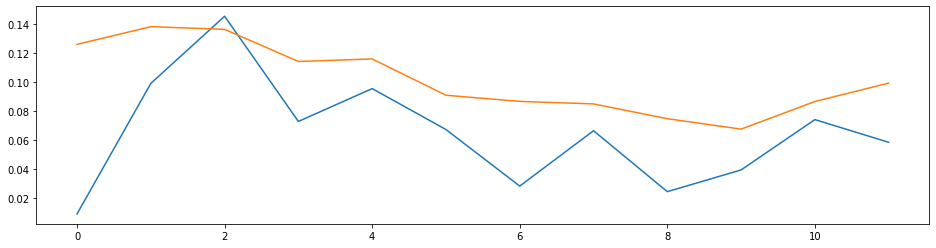

In [129]:
plt.plot(ff[113])
plt.plot(ffm)

# Cross-validation

In [233]:
def cv_split(train_df, n_splits=4):
    train_df = train_df.sample(frac=1, ignore_index=True)
    
    split_idx = [0] + [i*int(train_df.shape[0]/n_splits) for i in range(1, n_splits)] + [train_df.shape[0]]
    splits = {}
    print(split_idx)
    for i in range(len(split_idx)-1):
        x_train = train_df.loc[split_idx[i]:split_idx[i+1], [col for col in train_df.columns if col != "LABELS"]]
        y_train = train_df.loc[split_idx[i]:split_idx[i+1], "LABELS"]
        splits[i] = [x_train, y_train]
    
    return splits

In [234]:
splits = cv_split(train_df)

[0, 15026, 30052, 45078, 60106]


In [239]:
x_train, y_train = splits[0][0], splits[0][1]
x_val1, y_val1 = splits[1][0], splits[1][1]

# LGBM

In [240]:
lgbm = LGBMClassifier(
    boosting_type="gbdt",
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.1,
    n_estimators=100,
    objective="binary",
    n_jobs=8
    )

In [297]:
def lgbm_f1(y_true, y_pred):
    y_bin = np.where(y_pred > 0.5, 1, 0)
    eval_score = f1_score(y_true, y_bin)
    return ("f1_score", eval_score, True)

In [298]:
lgbm = lgbm.fit(
    x_train, y_train,
    eval_set=[(x_train, y_train), (x_val1, y_val1)],
    eval_metric=["logloss", "error", lgbm_f1])

[1]	training's binary_logloss: 0.596199	training's binary_error: 0.32029	training's f1_score: 0.809318	valid_1's binary_logloss: 0.601305	valid_1's binary_error: 0.324749	valid_1's f1_score: 0.806149
[2]	training's binary_logloss: 0.570625	training's binary_error: 0.32029	training's f1_score: 0.809318	valid_1's binary_logloss: 0.577087	valid_1's binary_error: 0.324749	valid_1's f1_score: 0.806149
[3]	training's binary_logloss: 0.548137	training's binary_error: 0.319225	training's f1_score: 0.809832	valid_1's binary_logloss: 0.556048	valid_1's binary_error: 0.323285	valid_1's f1_score: 0.806854
[4]	training's binary_logloss: 0.529396	training's binary_error: 0.28349	training's f1_score: 0.827054	valid_1's binary_logloss: 0.538987	valid_1's binary_error: 0.287017	valid_1's f1_score: 0.82421
[5]	training's binary_logloss: 0.513487	training's binary_error: 0.249551	training's f1_score: 0.84345	valid_1's binary_logloss: 0.52455	valid_1's binary_error: 0.256605	valid_1's f1_score: 0.83858
[6

In [300]:
def plot_evals(model):
    sets = list(model.evals_result_.keys())
    n_sets = len(sets)
    metrics = list(model.evals_result_[sets[0]].keys())
    n_metrics = len(metrics)
    
    fig, ax = plt.subplots(1, n_metrics)
    
    for i, seti in enumerate(sets):
        for j, metric in enumerate(metrics):
            ax[j].set_title(f"{metric}")
            ax[j].plot(model.evals_result_[seti][metric], label=f"{seti}")

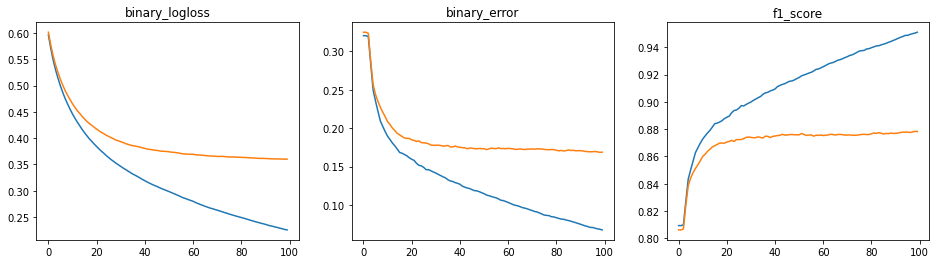

In [301]:
plot_evals(lgbm)

# Save prediction

In [ ]:
def save_pred(y, sub_id):
    original_index = test_df.index
    output_df = pd.DataFrame(y, index=original_index, columns=["LABELS"], dtype=int)
    output_df.to_csv(f"./submission/submission{sub_id}.csv")